In [1]:
import pandas
import wordcloud
import matplotlib.pyplot as plt
import random as rnd
from sklearn.linear_model import LinearRegression
import numpy as np
import math
import nltk

nltk.download('averaged_perceptron_tagger')

data = pandas.read_csv('data.csv', usecols=range(1, 11))

data.head(n=5)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/miha/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,Name,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,Martine of Martine's Table,Amsterdam,"['French', 'Dutch', 'European']",1.0,5.0,$$ - $$$,136.0,"[['Just like home', 'A Warm Welcome to Wintry ...",/Restaurant_Review-g188590-d11752080-Reviews-M...,d11752080
1,De Silveren Spiegel,Amsterdam,"['Dutch', 'European', 'Vegetarian Friendly', '...",2.0,4.5,$$$$,812.0,"[['Great food and staff', 'just perfect'], ['0...",/Restaurant_Review-g188590-d693419-Reviews-De_...,d693419
2,La Rive,Amsterdam,"['Mediterranean', 'French', 'International', '...",3.0,4.5,$$$$,567.0,"[['Satisfaction', 'Delicious old school restau...",/Restaurant_Review-g188590-d696959-Reviews-La_...,d696959
3,Vinkeles,Amsterdam,"['French', 'European', 'International', 'Conte...",4.0,5.0,$$$$,564.0,"[['True five star dinner', 'A superb evening o...",/Restaurant_Review-g188590-d1239229-Reviews-Vi...,d1239229
4,Librije's Zusje Amsterdam,Amsterdam,"['Dutch', 'European', 'International', 'Vegeta...",5.0,4.5,$$$$,316.0,"[['Best meal.... EVER', 'super food experience...",/Restaurant_Review-g188590-d6864170-Reviews-Li...,d6864170


In [2]:
data.loc[0]

Name                                        Martine of Martine's Table
City                                                         Amsterdam
Cuisine Style                          ['French', 'Dutch', 'European']
Ranking                                                              1
Rating                                                               5
Price Range                                                   $$ - $$$
Number of Reviews                                                  136
Reviews              [['Just like home', 'A Warm Welcome to Wintry ...
URL_TA               /Restaurant_Review-g188590-d11752080-Reviews-M...
ID_TA                                                        d11752080
Name: 0, dtype: object

In [3]:
isLjubljana = data['City'] == 'Ljubljana'
data_lj = data[isLjubljana]

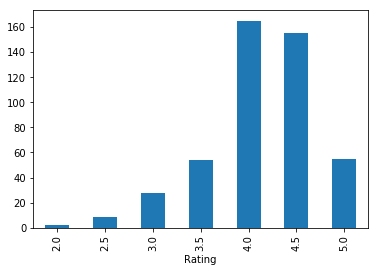

In [4]:
###############################################
# Restaurant rating distribution in Ljubljana #
###############################################

ratings_lj = data_lj['Rating']
vc = ratings_lj.value_counts().sort_index()
ax = vc.plot(kind='bar').set(xlabel="Rating")
plt.show()

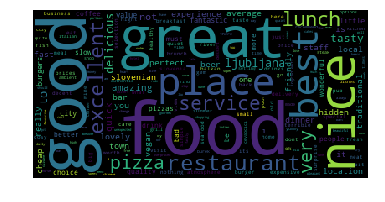

In [5]:
##################################################
# Review word-cloud for restaurants in Ljubljana #
##################################################
import collections as col
import wordcloud
import nltk


occurence_counter = col.Counter()

reviews_lj = data_lj['Reviews']
for revs_restaurant in reviews_lj:
    if not isinstance(revs_restaurant, str):
        continue
    words = revs_restaurant.split(' ');
    for w in words:
        parsed_word = ''.join(c for c in w if c.isalpha()).lower()
        if parsed_word == '':
            continue
        tagged = nltk.pos_tag([parsed_word])
        
        # We want to avoid conjunctions, prepositions, determiners, adpositions and pronouns
        if tagged[0][1] not in ['CC', 'PRON', 'IN', 'DT', 'ADP']:
            occurence_counter[parsed_word] += 1
        
cloud = wordcloud.WordCloud()       
cloud = cloud.generate_from_frequencies(occurence_counter)     


plt.imshow(cloud)
plt.axis("off")
plt.show()


In [6]:
############################################
# Most popular cuisine styles in Ljubljana #
############################################

# INFO: you can parse the arrays inside strings with eval(str)

def countCuisines(data_df):
    occurence_counter = col.Counter()

    for styles in data_df['Cuisine Style']:
        if not isinstance(styles, str):
            continue
        styles_arr = eval(styles)
        for s in styles_arr:
            occurence_counter[s] += 1

    return pandas.Series(occurence_counter, name='count')



df_count = countCuisines(data_lj).to_frame().reset_index()
df_count.columns = ['Cuisine_style', 'count']
df_count = df_count.sort_values(by=['count'], ascending=False).head(n=15).reset_index()[['Cuisine_style','count']]
df_count.index = df_count.index + 1
df_count

,Cuisine_style,count
1,European,247
2,Slovenian,174
3,Vegetarian Friendly,129
4,Central European,117
5,Mediterranean,87
6,Vegan Options,65
7,Italian,64
8,Pizza,62
9,Gluten Free Options,61
10,Bar,51


In [7]:
################################################################################################
# Construct a dataframe, where the columns represent the cuisine style distribution in a city. #
################################################################################################

all_styles = set()

for styles in data['Cuisine Style']:
    if not isinstance(styles, str):
        continue
    styles_arr = eval(styles)
    for s in styles_arr:
        all_styles.add(s)

df_allstyles = pandas.Series(list(all_styles)).to_frame()
df_allstyles.columns = ['Cuisine_style']


In [8]:
# Calculate cuisine style popularity vectors for each city, normalize them and add them to dataframe

for grp in data.groupby('City'):
    df_city = grp[1]
    df_counts = countCuisines(df_city)

    # Divide count by number of all cuisine style in the dataset
    #df_counts = df_counts.apply(lambda x: x / df_counts.sum())
    

    df_counts = df_counts.to_frame().reset_index()
    df_counts.columns = ['Cuisine_style', grp[0]]   # Set city name as column name
    
    df_allstyles = df_allstyles.merge(df_counts, on='Cuisine_style', how='left')

df_allstyles = df_allstyles.fillna(0.0)

df_allstyles.index = df_allstyles['Cuisine_style']
df_allstyles = df_allstyles.drop(['Cuisine_style'], axis=1)

df_allstyles.head(n=10)

,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,...,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich
Cuisine_style,,,,,,,,,,,,,,,,,,,,,
Caucasian,0.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,7.0,0.0,0.0,0.0
Czech,0.0,3.0,0.0,0.0,34.0,0.0,4.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,1874.0,0.0,1.0,6.0,7.0,0.0
British,19.0,7.0,12.0,6.0,3.0,13.0,9.0,6.0,57.0,696.0,...,1.0,1.0,3.0,29.0,12.0,8.0,18.0,7.0,6.0,8.0
Seafood,133.0,78.0,293.0,132.0,21.0,81.0,38.0,48.0,51.0,46.0,...,118.0,44.0,40.0,180.0,63.0,862.0,52.0,85.0,24.0,33.0
Canadian,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0
Italian,405.0,124.0,619.0,871.0,83.0,493.0,283.0,226.0,188.0,163.0,...,441.0,66.0,104.0,1356.0,429.0,3966.0,198.0,370.0,292.0,260.0
Brew Pub,4.0,9.0,45.0,12.0,12.0,41.0,10.0,7.0,7.0,5.0,...,8.0,5.0,6.0,98.0,18.0,147.0,4.0,14.0,23.0,0.0
Danish,2.0,0.0,0.0,0.0,0.0,0.0,1.0,508.0,0.0,0.0,...,0.0,0.0,5.0,4.0,1.0,3.0,4.0,1.0,0.0,1.0
Irish,7.0,1.0,11.0,9.0,2.0,6.0,4.0,5.0,658.0,2.0,...,6.0,0.0,1.0,17.0,12.0,12.0,6.0,10.0,2.0,5.0


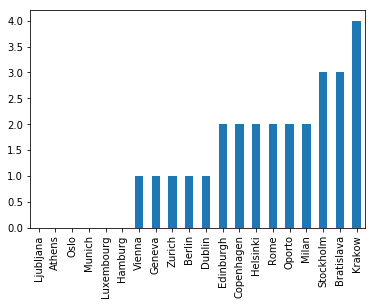

In [9]:
#########################################################################
# Find cities, where a certain cuisine style is not present yet or rare #
#########################################################################


# Belgian food:
belgian = df_allstyles.loc['Belgian'].sort_values(ascending=True).head(n=20)
belgian.plot(kind='bar')
plt.show()

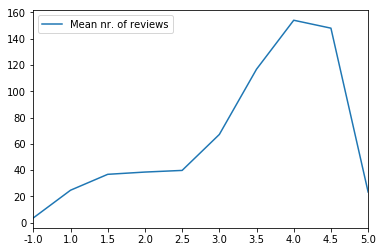

In [10]:
df_rat_nr = data[['Rating', 'Number of Reviews']]
df_rat_nr = df_rat_nr.dropna()

unique_ratings = df_rat_nr['Rating'].unique()
rating_mean_numrev = dict()
for rating in unique_ratings:
    mean = df_rat_nr[df_rat_nr['Rating'] == rating][['Number of Reviews']].mean()
    rating_mean_numrev[rating] = mean
    

result = pandas.DataFrame(rating_mean_numrev).T
result = result.rename(index=str, columns={"Number of Reviews": "Mean nr. of reviews"})
result = result.sort_index(axis=0, ascending=True)

result.plot(kind='line')
plt.show()

In [11]:
#################################################################
# Constructing a dataset of restaurants for regression learning #
#################################################################

restaurants = data.drop(columns=["Ranking", "Reviews", "URL_TA", "ID_TA"])

restaurants['NumOfSameType'] = 0.0
restaurants['Cuisine Style'] = restaurants['Cuisine Style'].fillna('Fck')
restaurants = restaurants[restaurants['Cuisine Style'] != "Fck"]
restaurants = restaurants[restaurants['Number of Reviews'] > 5.0]
restaurants['Rating'] = restaurants['Rating'].fillna(0.0)
restaurants['Price Range'] = restaurants['Price Range'].fillna("$")
restaurants['Number of Reviews'] = restaurants['Number of Reviews'].fillna(0.0)
restaurants['ID'] = range(0, len(restaurants))

restaurants = restaurants.set_index('ID')

# Replacement of dollar signs in price range
price_range = []
for entry in restaurants['Price Range']:
    if entry == "":
        price_range.append(0)
    elif entry == "$":
        price_range.append(1)
    elif entry == "$$" :
        price_range.append(2)
    elif entry == "$$$" or entry == "$$ - $$$":
        price_range.append(3)
    elif entry == "$$$$":
        price_range.append(4)
    else:
        print(entry)
        price_range.append(-1)
      
restaurants['Price Range'] = price_range

In [12]:
###########################################################
# How many restaurants of same style are in the same town #
###########################################################
#
#    SPODNJA KODA JE ZE POGNANA IN ZAPISANA 
#    V FILE "NumOfSameType.txt"
#    read je v naslednjem odseku
#
###########################################################
'''
sums = list()
lim = 1

for row in restaurants.iterrows():
    row = pandas.DataFrame.from_dict(row[1]).T.set_index('Name')
    #if (lim > 4):
    #    break
    #else:
    #    lim += 1
    sumSameStyle = 0
    city = row['City']
    
    if not isinstance(row['Cuisine Style'][0], str):
        continue
        
    styles = row['Cuisine Style'][0]
    styles_arr = eval(styles)
    for s in styles_arr:
        sumSameStyle += df_allstyles.loc[s, city][0]
    sums.append(sumSameStyle)
    
    
#sums
'''
print('')

In [13]:
###########################################################################
# DON'T RUN -- ONLY run it when changing the initial restaurant dataframe #
###########################################################################
# 
# vse vsote zapisi v file da ni treba laufat vsakic 10 minut
#
#with open("NumOfSameType.txt", 'w') as myfile:
    #wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    #wr.writerow(sums)

In [14]:
#restaurants['NumOfSameType'] = sums
with open('NumOfSameType.txt', 'r') as f:
    vals = f.read().split(',')
    restaurants['NumOfSameType'] = [float(i) for i in vals]

In [15]:
####################################################################
# Dodajanje atributa SuccRating - ocena kk uspesna je restavracija #
####################################################################

restaurants['SuccRating'] = ((restaurants['Rating'] ** 2)  * (restaurants['Number of Reviews']) / restaurants['NumOfSameType'])

restaurants.head(5)

,Name,City,Cuisine Style,Rating,Price Range,Number of Reviews,NumOfSameType,SuccRating
ID,,,,,,,,
0,Martine of Martine's Table,Amsterdam,"['French', 'Dutch', 'European']",5.0,3,136.0,2605.0,1.305182
1,De Silveren Spiegel,Amsterdam,"['Dutch', 'European', 'Vegetarian Friendly', '...",4.5,4,812.0,4243.0,3.875324
2,La Rive,Amsterdam,"['Mediterranean', 'French', 'International', '...",4.5,4,567.0,4368.0,2.628606
3,Vinkeles,Amsterdam,"['French', 'European', 'International', 'Conte...",5.0,4,564.0,4570.0,3.085339
4,Librije's Zusje Amsterdam,Amsterdam,"['Dutch', 'European', 'International', 'Vegeta...",4.5,4,316.0,5155.0,1.241319


In [16]:
##################################################
# Pripravi test in learn set in testiraj dolzino #
##################################################
#
# 7 : 3 = učna : testna
# 


learnBoolArr = []
for ID in restaurants.index:
    r = rnd.randint(0, 10)
    if r < 8:
        learnBoolArr.append(True)
    else:
        learnBoolArr.append(False)

# test set
learn = restaurants[learnBoolArr]
learn

# learn set
testBoolarr = [not e for e in learnBoolArr]
test = restaurants[testBoolarr]
test



print(len(learn))
print(len(test))

if (len(learn) + len(test) == len(restaurants.index)):
    print("Correct lenghts!")


55993
20864
Correct lenghts!


In [17]:
learn.head(5)

,Name,City,Cuisine Style,Rating,Price Range,Number of Reviews,NumOfSameType,SuccRating
ID,,,,,,,,
1,De Silveren Spiegel,Amsterdam,"['Dutch', 'European', 'Vegetarian Friendly', '...",4.5,4,812.0,4243.0,3.875324
3,Vinkeles,Amsterdam,"['French', 'European', 'International', 'Conte...",5.0,4,564.0,4570.0,3.085339
4,Librije's Zusje Amsterdam,Amsterdam,"['Dutch', 'European', 'International', 'Vegeta...",4.5,4,316.0,5155.0,1.241319
5,Ciel Bleu Restaurant,Amsterdam,"['Contemporary', 'International', 'Vegetarian ...",4.5,4,745.0,2834.0,5.323306
6,Zaza's,Amsterdam,"['French', 'International', 'Mediterranean', '...",4.5,3,1455.0,4882.0,6.035180


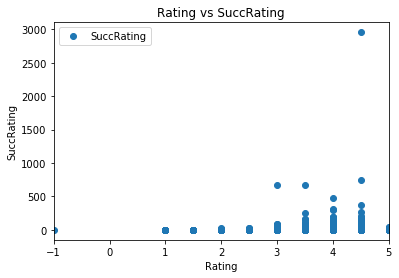

In [18]:
#########################################################
# Samo ocena kako sta v korelaciji Rating in Succrating #
#########################################################

learn.plot(x="Rating", y='SuccRating',  style="o")
plt.title('Rating vs SuccRating')  
plt.xlabel('Rating')  
plt.ylabel('SuccRating')  
plt.show()

In [19]:
test = test.drop(columns=['City', 'Cuisine Style', 'Name'])

learn = learn.drop(columns=['City', 'Cuisine Style', 'Name'])


In [20]:
learn.head(2)

,Rating,Price Range,Number of Reviews,NumOfSameType,SuccRating
ID,,,,,
1,4.5,4,812.0,4243.0,3.875324
3,5.0,4,564.0,4570.0,3.085339


In [21]:
####################################################################
# Učenje linearnega regresorja in razdelitev na atribute in labele #
####################################################################
#
# neodvisne spremenljivke, katerih valuesi se nucajo za napovedovanje
#
attributes = learn.drop(columns=['SuccRating'])
#
# spremenlijvke katerih valuesi se bodo napovedovali
#
labels = learn['SuccRating']

model = LinearRegression()  
model.fit(attributes, labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [22]:
y_pred = model.predict(test.drop(columns=['SuccRating']))

In [23]:
print(test[0:4]['SuccRating'].values)
print(y_pred[0:4])

def MSE(Y, YH):
     return np.square(Y - YH).mean()

#test

[1.30518234 2.62860577 6.43620868 3.63837793]
[2.9042076  4.16617775 6.23403989 5.20176411]


In [24]:
#############################################################################################
# Napovedane in dejanske podatke spravimo v svoj dataframe in kasneje dodamo še MSE stolpec #
#############################################################################################

predicitons = pandas.DataFrame(test['SuccRating'])
pred_vs_actual = pandas.DataFrame()
pred_vs_actual['Predicted'] = y_pred
pred_vs_actual['Actual'] = test['SuccRating'].values

pred_vs_actual.head(10)


,Predicted,Actual
0,2.904208,1.305182
1,4.166178,2.628606
2,6.234040,6.436209
3,5.201764,3.638378
4,7.675188,7.032805
5,3.476871,2.345969
6,8.578718,14.864362
7,11.621160,11.194659
8,9.443351,8.549187
9,2.398097,1.772150


In [25]:
#################################
# Računanje MSE za vse elemente #
#################################

mse_arr = []
for row in range(0, len(pred_vs_actual)):
    this_row = pred_vs_actual[row:row+1].values[0]
    mse_arr.append(MSE(this_row[0], this_row[1]))
                   


In [26]:
########################################
# IZRAČUN KOLIKO OCEN CCA JE UPORABNIH #
########################################


pred_vs_actual['MSE'] = mse_arr

# all cool
len1 = len(pred_vs_actual[pred_vs_actual['MSE'] < 2])
len2 = len(pred_vs_actual.index)

# cool asf
print(len1, len2)

# eh? a je butast
print(len1 / len2)

# wtf?
print((len1+0) / (len2+0))

# still wtf but now it works
print(float(len1+0) / (len2+0))

#fuck i hate python
print ("-----\nProcent uporabnih ocen: " + str(float(len1+0) / (len2+0) * 100))

12799 20864
0.6134490030674846
0.6134490030674846
0.6134490030674846
-----
Procent uporabnih ocen: 61.344900306748464
